In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score 
from sklearn.model_selection import GridSearchCV

plt.style.use('ggplot')

In [124]:
## This is a Kaggle competition where we need predict the Appliances Energy Consuption

In [2]:
# Setting the names from columns
col_names = ['date', 'Appliances_energy', 'Lights_energy', 'T_kitchen', 'RH_kitchen',
       'T_livingroom', 'RH_livingroom', 'T_laundryroom', 'RH_laundryroom',
       'T_officeroom', 'RH_officeroom', 'T_bathroom', 'RH_bathroom',
       'T_OutsideBuliding', 'RH_OutsideBuilding', 'T_ironingroom',
       'RH_ironingroom', 'T_teenagerroom2', 'RH_teenagerroom2',
       'T_parentsroom', 'RH_parentsroom', 'T_out', 'Press_mm_hg', 'RH_out',
       'Windspeed', 'Visibility', 'Tdewpoint', 'rv1', 'rv2','NSM','WeekStatus','Day_of_week']

# Reading dataset
train = pd.read_csv('projeto8-data_files/projeto8-training.csv')
test = pd.read_csv('projeto8-data_files/projeto8-testing.csv')

train.columns = col_names
test.columns = col_names

train.shape,test.shape

((14803, 32), (4932, 32))

In [3]:
#train.head().transpose()
#train.describe().transpose()
#train.isna().sum()

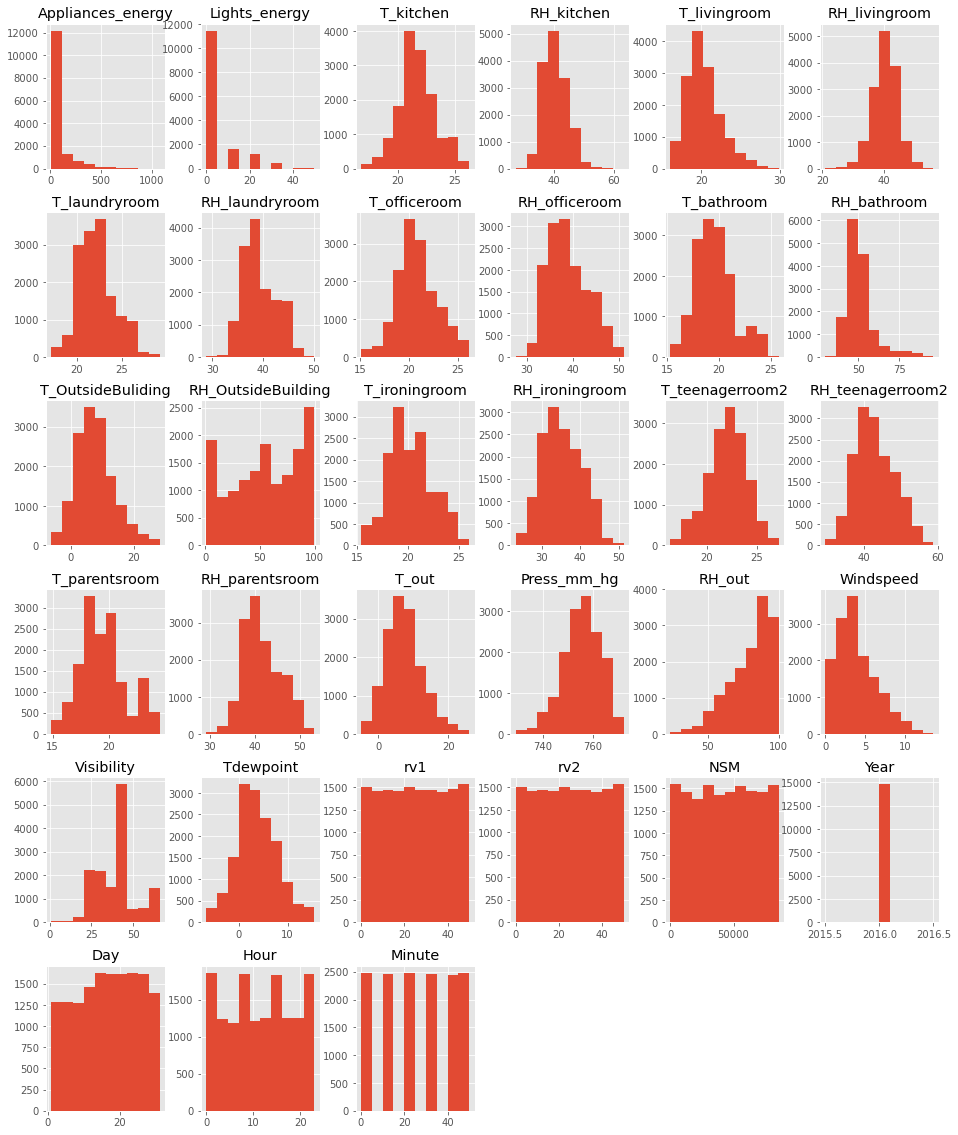

In [4]:
# Creating time-related features
train['date'] = pd.to_datetime(train['date'])
train['Year'] = pd.DatetimeIndex(train['date']).year
train['Month'] = pd.DatetimeIndex(train['date']).month_name()
train['Day'] = pd.DatetimeIndex(train['date']).day
train['Hour'] = pd.DatetimeIndex(train['date']).hour
train['Minute'] = pd.DatetimeIndex(train['date']).minute

test['date'] = pd.to_datetime(test['date'])
test['Year'] = pd.DatetimeIndex(test['date']).year
test['Month'] = pd.DatetimeIndex(test['date']).month_name()
test['Day'] = pd.DatetimeIndex(test['date']).day
test['Hour'] = pd.DatetimeIndex(test['date']).hour
test['Minute'] = pd.DatetimeIndex(test['date']).minute

# Hist plot
train.drop(['date'],axis=1).hist(figsize= (16,20))
plt.show()

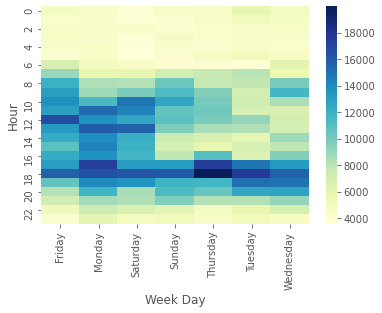

In [5]:
# Checking peaks with heatmap
heat_map = pd.pivot_table(train, 
               values='Appliances_energy',
               columns=['Day_of_week'],
               aggfunc=np.sum,index=['Hour'],
               fill_value=0)

sns.heatmap(heat_map, cmap="YlGnBu")
plt.xlabel("Week Day")
plt.ylabel("Hour")
plt.show()

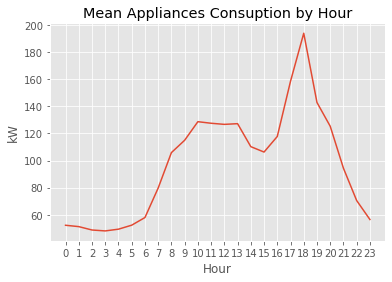

In [6]:
# Plotting average hour consuption
train.groupby(['Hour'])['Appliances_energy'].mean().plot()
plt.xticks(np.unique(train['Hour']))
plt.ylabel("kW")
plt.title("Mean Appliances Consuption by Hour")
plt.show()

In [7]:
# Creating categorical hour by criteria above
train['Hour_range'] = pd.cut(train['Hour'],[0,8,16,20,23],include_lowest=True).astype('object')
test['Hour_range'] = pd.cut(test['Hour'],[0,8,16,20,23],include_lowest=True).astype('object')

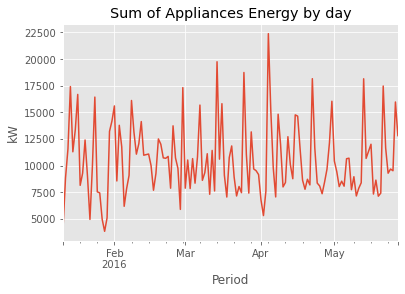

In [8]:
# See appliances over the period
train.groupby(pd.DatetimeIndex(train['date']).to_period("D"))['Appliances_energy'].sum().plot()
plt.xlabel("Period")
plt.ylabel("kW")
plt.title("Sum of Appliances Energy by day")
plt.show()

In [9]:
# calculate interquartile range
q25, q75 = np.percentile(train['Appliances_energy'], 25), np.percentile(train['Appliances_energy'], 75)
iqr = q75 - q25

# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

# identify outliers
train_no_out = train.loc[(train['Appliances_energy'] > lower) & (train['Appliances_energy'] < upper)]

# identify outliers
test_no_out = test.loc[(test['Appliances_energy'] > lower) & (test['Appliances_energy'] < upper)]

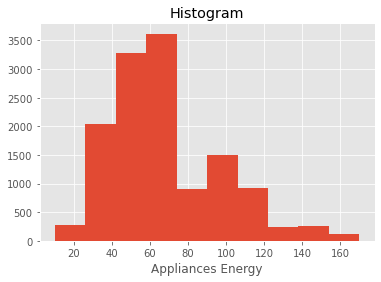

In [10]:
# Checking target after outlier removal
plt.hist(train_no_out['Appliances_energy'])
plt.xlabel("Appliances Energy")
plt.title("Histogram")
plt.show()

In [11]:
# Splitting in X and y
y_train = train_no_out['Appliances_energy'].values
X_train = train_no_out.drop(['Appliances_energy','date','Year'],axis=1)

y_test = test_no_out['Appliances_energy'].values
X_test = test_no_out.drop(['Appliances_energy','date','Year'],axis=1)

train.shape,train_no_out.shape,test.shape,test_no_out.shape

((14803, 38), (13169, 38), (4932, 38), (4428, 38))

In [12]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Lights_energy       13169 non-null  int64  
 1   T_kitchen           13169 non-null  float64
 2   RH_kitchen          13169 non-null  float64
 3   T_livingroom        13169 non-null  float64
 4   RH_livingroom       13169 non-null  float64
 5   T_laundryroom       13169 non-null  float64
 6   RH_laundryroom      13169 non-null  float64
 7   T_officeroom        13169 non-null  float64
 8   RH_officeroom       13169 non-null  float64
 9   T_bathroom          13169 non-null  float64
 10  RH_bathroom         13169 non-null  float64
 11  T_OutsideBuliding   13169 non-null  float64
 12  RH_OutsideBuilding  13169 non-null  float64
 13  T_ironingroom       13169 non-null  float64
 14  RH_ironingroom      13169 non-null  float64
 15  T_teenagerroom2     13169 non-null  float64
 16  RH_t

In [15]:
## Pipeline for preprocess X
# Creating custom transformation for the text
numeric_features = X_train.select_dtypes(exclude=['object']).columns
numeric_transformer = StandardScaler()

# One Hot encoding for categoricals columns
categorical_features = X_train.select_dtypes('object').columns
categorical_transformer = OrdinalEncoder()

# Passing the parameters
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Finishing pipeline
pre_process = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

In [16]:
# Preprocessing the data
X_train_preprocessed = pre_process.fit_transform(X_train)
X_test_preprocessed = pre_process.transform(X_test)

X_train_preprocessed.shape,X_test_preprocessed.shape

((13169, 35), (4428, 35))

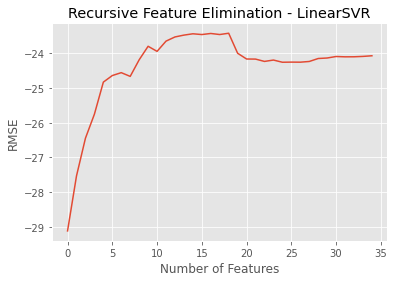

In [76]:
# Selecting features using RFE with LinearSVR
rfecv = RFECV(estimator=LinearSVR(),cv=5,scoring="neg_root_mean_squared_error")
rfecv.fit(X_train_preprocessed, y_train)
plt.plot(rfecv.grid_scores_)
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Recursive Feature Elimination - LinearSVR")
plt.show()

In [49]:
# Columns selected by RFE
X_train.columns[rfecv.support_]

Index(['Lights_energy', 'T_kitchen', 'RH_kitchen', 'T_livingroom',
       'RH_livingroom', 'RH_laundryroom', 'T_officeroom', 'RH_bathroom',
       'T_ironingroom', 'RH_ironingroom', 'T_teenagerroom2',
       'RH_teenagerroom2', 'T_parentsroom', 'RH_parentsroom', 'T_out', 'NSM',
       'Day_of_week', 'Day', 'Hour_range'],
      dtype='object')

In [51]:
# Subset dataset with selected features
X_train_features = X_train_preprocessed[:,rfecv.support_]
X_test_features = X_test_preprocessed[:,rfecv.support_]

In [77]:
# Creating a list of models
models = [
           ['Linear Regression',LinearRegression()],
           ['Ridge',Ridge()],
           ['LinearSVR',LinearSVR()],
           ['KNeighborsRegressor' ,KNeighborsRegressor()],
           ['DecisionTreeRegressor',DecisionTreeRegressor()],
           ['RandomForestRegressor',RandomForestRegressor()],
           ['GradientBoostingRegressor', GradientBoostingRegressor()] ,
           ['XGBRegressor', xgb.XGBRegressor()]
         ]

In [84]:
%%time
# Training the models
for name, model in models: 
    print(name,'|\n')  
    #Fitting model
    model.fit(X_train_features, y_train)
    #Printing scores
    print('R2 Train:',r2_score(y_train,model.predict(X_train_features)))
    print('R2 Test:',r2_score(y_test,model.predict(X_test_features)))
    print('RMSE Test:',mean_squared_error(y_test,model.predict(X_test_features),squared=True),'\n')

Linear Regression |

R2 Train: 0.37821765868737045
R2 Test: 0.3600942790793725
RMSE Test: 535.7795988586986 

Ridge |

R2 Train: 0.3782159770368573
R2 Test: 0.3600741737264772
RMSE Test: 535.796432647735 

LinearSVR |

R2 Train: 0.3615055806193732
R2 Test: 0.3356649756001264
RMSE Test: 556.233740758973 

KNeighborsRegressor |

R2 Train: 0.7736202949319859
R2 Test: 0.6181397227102403
RMSE Test: 319.7235772357724 

DecisionTreeRegressor |

R2 Train: 1.0
R2 Test: 0.48609176688296474
RMSE Test: 430.2845528455285 

RandomForestRegressor |

R2 Train: 0.9597074729879265
R2 Test: 0.6986154539540439
RMSE Test: 252.3429403794038 

GradientBoostingRegressor |

R2 Train: 0.5714908202768504
R2 Test: 0.5271599952015142
RMSE Test: 395.89898919922496 

XGBRegressor |

R2 Train: 0.8609598961383915
R2 Test: 0.653509526787803
RMSE Test: 290.1091843325123 

Wall time: 19.4 s


In [110]:
# Selecting parameters to grid
param_grid = {
    'max_depth': [10, 25, None],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 4],
    'n_estimators': [100, 200]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,cv = 3, verbose = 2)

In [113]:
%%time
# Fit the grid search to the data
grid_search.fit(X_train_features, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   9.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   4.6s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_sam

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 25, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [100, 200]},
             verbose=2)

In [121]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=4,
                      n_estimators=200)

In [122]:
# Test the new model with the data
print('R2 Train:',r2_score(y_train,grid_search.predict(X_train_features)))
print('R2 Test:',r2_score(y_test,grid_search.predict(X_test_features)))
print('RMSE Test:',mean_squared_error(y_test,grid_search.predict(X_test_features),squared=True),'\n')

R2 Train: 0.7322635296563358
R2 Test: 0.6176967135681009
RMSE Test: 320.09449947119913 



In [123]:
# Both R2 and RMSE were worse with the GridSearch, so we shall use the default RandomForest model